In [1]:
# !pip install xgboost_ray
# !pip install "ray[all]" sklearn

In [2]:
# !pip install xgboost

In [1]:
import xgboost as xgb   # model training
from xgboost.sklearn import XGBClassifier
import pickle           # save model
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV
from sklearn import metrics   # Additional scklearn functions

import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

ref: https://blog.csdn.net/han_xiaoyang/article/details/52665396

In [51]:
%run 102-data_preprocessing.py

(16760, 104) (16760, 1)
(2394, 104) (2394, 1)


# Clean: Imbalanced Data

In [52]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler()
x_over, y_over = oversample.fit_resample(X_train_t1, y_train_t1)

X_train_t1 = pd.DataFrame(x_over)
y_train_t1 = pd.DataFrame(y_over)

In [53]:
# X_valid_t1 = X_valid_t1
X_test_t1 = pd.DataFrame(X_test_t1)

In [54]:
xgb_params = {
    'learning_rate':0.1,
    'n_estimators':1000,
    'max_depth':14,
    'min_child_weight':1,
    'gamma':0.0,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'scale_pos_weight':1,
     'tree_method':'gpu_hist', # if you have GPU and not using macOS, use this to speed up training
     'predictor':'gpu_predictor', 
     'sampling_method': 'gradient_based', 
    'objective':'binary:logistic',
    'seed':3612
}

# Optimization

In [55]:
def model_fit(model: xgb.XGBClassifier or xgb.XGBRegressor, 
              X: pd.DataFrame or np.array or list, 
              y: pd.DataFrame or np.array or list, 
              useTrainCV=True,
              cv_folds=5,
              early_stopping_rounds=50
              ) -> xgb.XGBClassifier or xgb.XGBRegressor:
    
    if useTrainCV:
        xgb_param = model.get_xgb_params()
        xgtrain = xgb.DMatrix(X.values, label=y.values)
        cvresult = xgb.cv(xgb_param, 
                          xgtrain, 
                          num_boost_round=model.get_params()['n_estimators'], 
                          nfold=cv_folds,
                          metrics='auc', 
                          early_stopping_rounds=early_stopping_rounds,
                          verbose_eval=True
                          )
        model.set_params(n_estimators=cvresult.shape[0])

    # fit the algorithm on the data
    model.fit(X, y, eval_metric='auc')
    
    # predict training set
    dtrain_predictions = model.predict(X)
    dtrain_predprob = model.predict_proba(X)[:,1]
    
    # print model report
    print('*'*10)
    print("Model Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(y.values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(y, dtrain_predprob))
    print('*'*10)
    
    sns.set_style('whitegrid')
    feat_imp = (pd.Series(model.get_booster().get_fscore())
                .sort_values(ascending=False))
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    
    return model

## 1 - Confirm the parameters by cross-validation

[0]	train-auc:0.96682+0.00280	test-auc:0.93744+0.00289
[1]	train-auc:0.99183+0.00068	test-auc:0.97842+0.00310
[2]	train-auc:0.99547+0.00077	test-auc:0.98726+0.00180
[3]	train-auc:0.99734+0.00057	test-auc:0.99107+0.00158
[4]	train-auc:0.99829+0.00025	test-auc:0.99278+0.00127
[5]	train-auc:0.99896+0.00009	test-auc:0.99434+0.00119
[6]	train-auc:0.99939+0.00006	test-auc:0.99572+0.00104
[7]	train-auc:0.99957+0.00008	test-auc:0.99619+0.00098
[8]	train-auc:0.99974+0.00005	test-auc:0.99708+0.00085
[9]	train-auc:0.99983+0.00002	test-auc:0.99773+0.00067
[10]	train-auc:0.99989+0.00002	test-auc:0.99801+0.00065
[11]	train-auc:0.99992+0.00003	test-auc:0.99832+0.00058
[12]	train-auc:0.99994+0.00003	test-auc:0.99855+0.00059
[13]	train-auc:0.99996+0.00002	test-auc:0.99870+0.00054
[14]	train-auc:0.99997+0.00001	test-auc:0.99881+0.00055
[15]	train-auc:0.99998+0.00001	test-auc:0.99883+0.00054
[16]	train-auc:0.99999+0.00000	test-auc:0.99894+0.00055
[17]	train-auc:0.99999+0.00000	test-auc:0.99901+0.00052
[1

[146]	train-auc:1.00000+0.00000	test-auc:0.99968+0.00021
[147]	train-auc:1.00000+0.00000	test-auc:0.99968+0.00021
[148]	train-auc:1.00000+0.00000	test-auc:0.99968+0.00021
[149]	train-auc:1.00000+0.00000	test-auc:0.99968+0.00021
[150]	train-auc:1.00000+0.00000	test-auc:0.99968+0.00021
[151]	train-auc:1.00000+0.00000	test-auc:0.99968+0.00021
[152]	train-auc:1.00000+0.00000	test-auc:0.99968+0.00021
[153]	train-auc:1.00000+0.00000	test-auc:0.99968+0.00021
[154]	train-auc:1.00000+0.00000	test-auc:0.99968+0.00022
[155]	train-auc:1.00000+0.00000	test-auc:0.99968+0.00022
[156]	train-auc:1.00000+0.00000	test-auc:0.99968+0.00022
[157]	train-auc:1.00000+0.00000	test-auc:0.99968+0.00021
[158]	train-auc:1.00000+0.00000	test-auc:0.99968+0.00021
[159]	train-auc:1.00000+0.00000	test-auc:0.99969+0.00021
[160]	train-auc:1.00000+0.00000	test-auc:0.99969+0.00021
[161]	train-auc:1.00000+0.00000	test-auc:0.99969+0.00021
[162]	train-auc:1.00000+0.00000	test-auc:0.99969+0.00021
[163]	train-auc:1.00000+0.00000

D:\anaconda3\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


**********
Model Report
Accuracy : 1
AUC Score (Train): 1.000000
**********


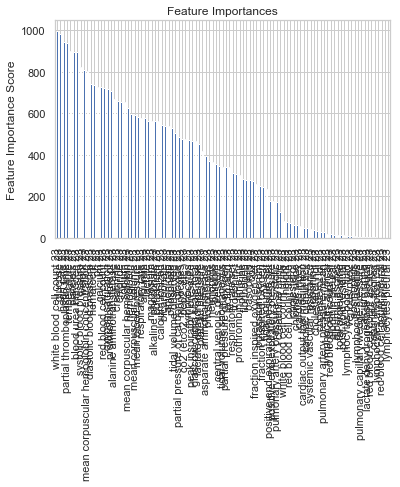

In [56]:
xgb1 = XGBClassifier(**xgb_params)

xgb2 = model_fit(xgb1, X_train_t1, y_train_t1)

In [57]:
print('best n_estimators:', xgb2.get_params()['n_estimators'])
print('best max_depth:', xgb2.get_params()['max_depth'])
print('best min_child_weight:', xgb2.get_params()['min_child_weight'])
print('best gamma:', xgb2.get_params()['gamma'])
print('best subsample:', xgb2.get_params()['subsample'])
print('best colsample_bytree:', xgb2.get_params()['colsample_bytree'])

best n_estimators: 209
best max_depth: 14
best min_child_weight: 1
best gamma: 0.0
best subsample: 0.8
best colsample_bytree: 0.8


In [58]:
xgb_params['n_estimators'] = xgb2.get_params()['n_estimators']

best n_estimators: 261
best max_depth: 14
best min_child_weight: 1
best gamma: 0.0
best subsample: 0.8
best colsample_bytree: 0.8

## 2 - Optimize `max_depth` and `min_child_weight` by grid search

In [59]:
xgb_params

{'learning_rate': 0.1,
 'n_estimators': 209,
 'max_depth': 14,
 'min_child_weight': 1,
 'gamma': 0.0,
 'subsample': 0.8,
 'colsample_bytree': 0.8,
 'scale_pos_weight': 1,
 'tree_method': 'gpu_hist',
 'predictor': 'gpu_predictor',
 'sampling_method': 'gradient_based',
 'objective': 'binary:logistic',
 'seed': 3612}

In [60]:
param_test1 = {
 'max_depth':[5,6,7,8,9,11,13,14,15,16,17], # range(3,12,2)
 'min_child_weight': [1,2,3,4,5,6,7] # range(1,6,2)
}

gsearch1 = HalvingGridSearchCV(estimator = XGBClassifier(**xgb_params),
                               param_grid = param_test1, 
                               scoring='roc_auc', 
                               n_jobs=4, 
                               cv=5
                               )

gsearch1.fit(X_train_t1.values, y_train_t1.values.ravel())

HalvingGridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=0.0,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, m...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=14,
                                            max_leaves=None, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=209, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor='gpu_predictor',
                                            random_state=None, ...),
                    n_jobs=4,
                    param_grid={'max_depth': [5, 6, 7, 8, 9, 11, 13, 14, 15, 16,
                                              17],
                                'min_child_weight': [1, 2, 3, 4, 5, 6, 7]},
                    scoring='roc_auc')

In [61]:
means = gsearch1.cv_results_["mean_test_score"]
stdevs = gsearch1.cv_results_["std_test_score"]
params = gsearch1.cv_results_["params"]

for mean, stdev, param in zip(means, stdevs, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print(gsearch1.best_score_, gsearch1.best_params_)

0.880725 (0.010415) with: {'max_depth': 5, 'min_child_weight': 1}
0.876733 (0.013220) with: {'max_depth': 5, 'min_child_weight': 2}
0.875718 (0.016605) with: {'max_depth': 5, 'min_child_weight': 3}
0.878426 (0.017254) with: {'max_depth': 5, 'min_child_weight': 4}
0.869240 (0.018670) with: {'max_depth': 5, 'min_child_weight': 5}
0.867463 (0.017334) with: {'max_depth': 5, 'min_child_weight': 6}
0.867985 (0.019007) with: {'max_depth': 5, 'min_child_weight': 7}
0.879026 (0.015068) with: {'max_depth': 6, 'min_child_weight': 1}
0.876582 (0.015134) with: {'max_depth': 6, 'min_child_weight': 2}
0.873468 (0.016038) with: {'max_depth': 6, 'min_child_weight': 3}
0.871061 (0.020376) with: {'max_depth': 6, 'min_child_weight': 4}
0.871811 (0.014151) with: {'max_depth': 6, 'min_child_weight': 5}
0.866624 (0.011768) with: {'max_depth': 6, 'min_child_weight': 6}
0.867649 (0.020624) with: {'max_depth': 6, 'min_child_weight': 7}
0.881504 (0.019169) with: {'max_depth': 7, 'min_child_weight': 1}
0.879477 (

In [62]:
xgb_params['max_depth'] = gsearch1.best_params_['max_depth']
xgb_params['min_child_weight'] = gsearch1.best_params_['min_child_weight']

0.9997171254585673

## 3 - Optimize `gamma` by grid search

In [63]:
param_test3 = {
    'gamma': [i/10.0 for i in range(0,6)]
}

gsearch3 = HalvingGridSearchCV(estimator = XGBClassifier(**xgb_params), 
                                param_grid = param_test3, 
                                scoring='roc_auc', 
                                n_jobs=4,
                                cv=5)

gsearch3.fit(X_train_t1.values, y_train_t1.values.ravel())

HalvingGridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=0.0,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=14,
                                            max_leaves=None, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=209, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor='gpu_predictor',
                                            random_state=None, ...),
                    n_jobs=4,
                    param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]},
                    scoring='roc_auc')

In [64]:
means = gsearch3.cv_results_["mean_test_score"]
stdevs = gsearch3.cv_results_["std_test_score"]
params = gsearch3.cv_results_["params"]

for mean, stdev, param in zip(means, stdevs, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print(gsearch3.best_params_, gsearch3.best_score_)

0.993094 (0.001525) with: {'gamma': 0.0}
0.992343 (0.001690) with: {'gamma': 0.1}
0.992611 (0.001644) with: {'gamma': 0.2}
0.992005 (0.002125) with: {'gamma': 0.3}
0.991849 (0.001879) with: {'gamma': 0.4}
0.991345 (0.002123) with: {'gamma': 0.5}
0.999499 (0.000230) with: {'gamma': 0.2}
0.999646 (0.000145) with: {'gamma': 0.0}
{'gamma': 0.0} 0.9996461058064054


In [65]:
xgb_params['gamma'] = gsearch3.best_params_['gamma']

0.9997333151509034

## 4 - Optimize `subsample` and `colsample_bytree` by grid search

In [66]:
param_test4 = {
    'colsample_bytree':[i/10.0 for i in range(1,10,1)],
    'subsample':[i/10.0 for i in range(1,10,1)]
}

gsearch4 = HalvingGridSearchCV(estimator = XGBClassifier(**xgb_params),
                               param_grid = param_test4, 
                               scoring='roc_auc',
                               n_jobs=4,
                               cv=5
                               )

gsearch4.fit(X_train_t1.values, y_train_t1.values.ravel())

HalvingGridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=0.0,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, m...
                                            max_delta_step=None, max_depth=14,
                                            max_leaves=None, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=209, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor='gpu_predictor',
                                            random_state=None, ...),
                    n_jobs=4,
                    param_grid={'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5,
                                                     0.6, 0.7, 0.8, 0.9],
                                'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                              0.8, 0.9]},
                    scoring='roc_auc')

In [67]:
means = gsearch4.cv_results_["mean_test_score"]
stdevs = gsearch4.cv_results_["std_test_score"]
params = gsearch4.cv_results_["params"]

for mean, stdev, param in zip(means, stdevs, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print(gsearch4.best_score_, gsearch4.best_params_)

0.833147 (0.062423) with: {'colsample_bytree': 0.1, 'subsample': 0.1}
0.859985 (0.052898) with: {'colsample_bytree': 0.1, 'subsample': 0.2}
0.862291 (0.031503) with: {'colsample_bytree': 0.1, 'subsample': 0.3}
0.860102 (0.036235) with: {'colsample_bytree': 0.1, 'subsample': 0.4}
0.863999 (0.037587) with: {'colsample_bytree': 0.1, 'subsample': 0.5}
0.869132 (0.035397) with: {'colsample_bytree': 0.1, 'subsample': 0.6}
0.870930 (0.034171) with: {'colsample_bytree': 0.1, 'subsample': 0.7}
0.860534 (0.042895) with: {'colsample_bytree': 0.1, 'subsample': 0.8}
0.863019 (0.037648) with: {'colsample_bytree': 0.1, 'subsample': 0.9}
0.829611 (0.024950) with: {'colsample_bytree': 0.2, 'subsample': 0.1}
0.851899 (0.038783) with: {'colsample_bytree': 0.2, 'subsample': 0.2}
0.853018 (0.038030) with: {'colsample_bytree': 0.2, 'subsample': 0.3}
0.858836 (0.035645) with: {'colsample_bytree': 0.2, 'subsample': 0.4}
0.872313 (0.032228) with: {'colsample_bytree': 0.2, 'subsample': 0.5}
0.870355 (0.027021) 

In [68]:
xgb_params['colsample_bytree'] = gsearch4.best_params_['colsample_bytree']
xgb_params['subsample'] = gsearch4.best_params_['subsample']

0.9998347063586867

## 5 - Optimize `reg_alpha` and `reg_lambda` by grid search

In [69]:
param_test5 = {
    'reg_alpha':[0, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.13, 0.15, 0.2, 0.5],
    'reg_lambda':[0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.5, 0, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.13,] # 
}

gsearch5 = HalvingGridSearchCV(estimator = XGBClassifier(**xgb_params),
                               param_grid = param_test5, 
                               scoring='roc_auc',
                               n_jobs=4,
                               cv=5
                               )

gsearch5.fit(X_train_t1.values, y_train_t1.values.ravel())

HalvingGridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.2,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=0.0,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, m...
                                            monotone_constraints=None,
                                            n_estimators=209, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor='gpu_predictor',
                                            random_state=None, ...),
                    n_jobs=4,
                    param_grid={'reg_alpha': [0, 0.005, 0.01, 0.02, 0.03, 0.04,
                                              0.05, 0.06, 0.07, 0.08, 0.09, 0.1,
                                              0.13, 0.15, 0.2, 0.5],
                                'reg_lambda': [0.14, 0.15, 0.16, 0.17, 0.18,
                                               0.19, 0.2, 0.5, 0, 0.005, 0.01,
                                               0.02, 0.03, 0.04, 0.05, 0.06,
                                               0.07, 0.08, 0.09, 0.1, 0.13]},
                    scoring='roc_auc')

In [70]:
means = gsearch5.cv_results_["mean_test_score"]
stdevs = gsearch5.cv_results_["std_test_score"]
params = gsearch5.cv_results_["params"]

for mean, stdev, param in zip(means, stdevs, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print(gsearch5.best_score_, gsearch5.best_params_)

0.769113 (0.064819) with: {'reg_alpha': 0, 'reg_lambda': 0.14}
0.763730 (0.063224) with: {'reg_alpha': 0, 'reg_lambda': 0.15}
0.773969 (0.059931) with: {'reg_alpha': 0, 'reg_lambda': 0.16}
0.773899 (0.050846) with: {'reg_alpha': 0, 'reg_lambda': 0.17}
0.766260 (0.071523) with: {'reg_alpha': 0, 'reg_lambda': 0.18}
0.765201 (0.077763) with: {'reg_alpha': 0, 'reg_lambda': 0.19}
0.777950 (0.056653) with: {'reg_alpha': 0, 'reg_lambda': 0.2}
0.758416 (0.078575) with: {'reg_alpha': 0, 'reg_lambda': 0.5}
0.776739 (0.061573) with: {'reg_alpha': 0, 'reg_lambda': 0}
0.779150 (0.066774) with: {'reg_alpha': 0, 'reg_lambda': 0.005}
0.802529 (0.062816) with: {'reg_alpha': 0, 'reg_lambda': 0.01}
0.780514 (0.053230) with: {'reg_alpha': 0, 'reg_lambda': 0.02}
0.767668 (0.099435) with: {'reg_alpha': 0, 'reg_lambda': 0.03}
0.758228 (0.056988) with: {'reg_alpha': 0, 'reg_lambda': 0.04}
0.753204 (0.078644) with: {'reg_alpha': 0, 'reg_lambda': 0.05}
0.760809 (0.062519) with: {'reg_alpha': 0, 'reg_lambda': 0.

In [76]:
xgb_params['reg_alpha'] = 0.13
xgb_params['reg_lambda'] = gsearch5.best_params_['reg_lambda']

In [75]:
gsearch5.best_params_['reg_alpha']

0.13

0.9997205558345001

## 6 - Optimize `learning_rate` by grid search

In [80]:
param_test6 = {
    'learning_rate':[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 
                     0.1, 0.11, 0.13, 0.15, 0.17, 0.2, 0.3, 0.5]
}

gsearch6 = HalvingGridSearchCV(estimator = XGBClassifier(**xgb_params),
                               param_grid = param_test6,
                               scoring='roc_auc',
                               n_jobs=4,
                               cv=5
                               )

gsearch6.fit(X_train_t1.values, y_train_t1.values.ravel())

HalvingGridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.2,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=0.0,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, m...
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=14,
                                            max_leaves=None, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=2000, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor='gpu_predictor',
                                            random_state=None, ...),
                    n_jobs=4,
                    param_grid={'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05,
                                                  0.06, 0.07, 0.08, 0.09, 0.1,
                                                  0.11, 0.13, 0.15, 0.17, 0.2,
                                                  0.3, 0.5]},
                    scoring='roc_auc')

In [81]:
means = gsearch6.cv_results_["mean_test_score"]
stdevs = gsearch6.cv_results_["std_test_score"]
params = gsearch6.cv_results_["params"]

for mean, stdev, param in zip(means, stdevs, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print(gsearch6.best_params_, gsearch6.best_score_)

0.953929 (0.007794) with: {'learning_rate': 0.01}
0.953504 (0.007493) with: {'learning_rate': 0.02}
0.952579 (0.008552) with: {'learning_rate': 0.03}
0.951582 (0.008708) with: {'learning_rate': 0.04}
0.951267 (0.008857) with: {'learning_rate': 0.05}
0.951864 (0.008238) with: {'learning_rate': 0.06}
0.950924 (0.008270) with: {'learning_rate': 0.07}
0.950656 (0.008623) with: {'learning_rate': 0.08}
0.949503 (0.008294) with: {'learning_rate': 0.09}
0.950498 (0.009091) with: {'learning_rate': 0.1}
0.949834 (0.008012) with: {'learning_rate': 0.11}
0.950421 (0.009560) with: {'learning_rate': 0.13}
0.949806 (0.008537) with: {'learning_rate': 0.15}
0.950001 (0.009612) with: {'learning_rate': 0.17}
0.949057 (0.009220) with: {'learning_rate': 0.2}
0.945518 (0.006285) with: {'learning_rate': 0.3}
0.942051 (0.010816) with: {'learning_rate': 0.5}
0.994328 (0.001017) with: {'learning_rate': 0.05}
0.994454 (0.000592) with: {'learning_rate': 0.04}
0.994243 (0.001002) with: {'learning_rate': 0.06}
0.99

In [82]:
xgb_params['learning_rate'] = gsearch6.best_params_['learning_rate']

# Best Model

In [83]:
xgb_params['n_estimators'] = 2000

In [84]:
## best model
xgbModel_best = XGBClassifier(**xgb_params)

xgbModel_best.fit(X_train_t1.values, y_train_t1.values.ravel())
## save model
pickle.dump(xgbModel_best, open(os.path.join(path_y_t1, 'xgbModel_best_v1.4.pkl'), "wb"))

In [ ]:
# from xgboost import plot_tree
# # Scaling by 0.505149 to fit
# plot_tree(xgbModel_best, rankdir='LR', scale=0.5)

# Validation

In [ ]:
y_pred = xgbModel_best.predict(X_valid_t1)

In [ ]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

## plot the confusion matrix
sns.set_style('whitegrid')
cm = confusion_matrix(y_valid_t1, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [ ]:
print(classification_report(y_valid_t1, y_pred))

In [ ]:
## plot the ROC curve
from sklearn.metrics import roc_curve, auc

sns.set_theme(style="whitegrid")
fpr, tpr, thresholds = roc_curve(y_valid_t1, y_pred)
roc_auc = auc(fpr, tpr)
sns.lineplot(x=fpr, y=tpr, label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.0,1.0])
plt.ylim([-0.0,1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [85]:
## pred the test data and save it
y_pred_test = xgbModel_best.predict_proba(X_test_t1)[::,1]
y_pred_test = pd.DataFrame(y_pred_test, columns=['Predicted'])

X_test_1 = pd.read_csv(os.path.join(path_X, 'X_test.csv'), index_col=[0], header=[0,1,2])
y_pred_test.index = X_test_1.index # set the index
y_pred_test.reset_index(inplace=True) # reset the index
y_pred_test.rename({'index':'Id'}, axis=1, inplace=True) # rename the index column
y_pred_test.to_csv(os.path.join(path_y_t1, 'y_test_last.csv'), index=False)